In [2]:
pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 5.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False


In [4]:
import pandas as pd
from google.colab import drive


# Mount Google Drive
drive.mount('/content/drive')

# Read the CSV file from Google Drive
file_path = '/content/drive/MyDrive/creditcard.csv'
card = pd.read_csv(file_path)

# Now 'card' should contain the data from the CSV file


Mounted at /content/drive


In [5]:
card

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [6]:
card.shape

(284807, 31)

In [7]:
df = card.copy()
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(283726, 31)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def draw_histograms(dataframe, features, rows, cols):
    fig = plt.figure(figsize=(20, 20))
    for i, feature in enumerate(features):  # Loop for list of features
        ax = fig.add_subplot(rows, cols, i + 1)  # Add a subplot to the figure (specified by rows and columns)
        dataframe[feature].hist(bins=20, ax=ax, facecolor='orange')  # histogram for the current feature
        ax.set_title(feature + " Distribution", color='Black')  #title for the histogram
        ax.set_yscale('log')  # Set the y-axis scale to logarithmic
    fig.tight_layout()
    plt.show()

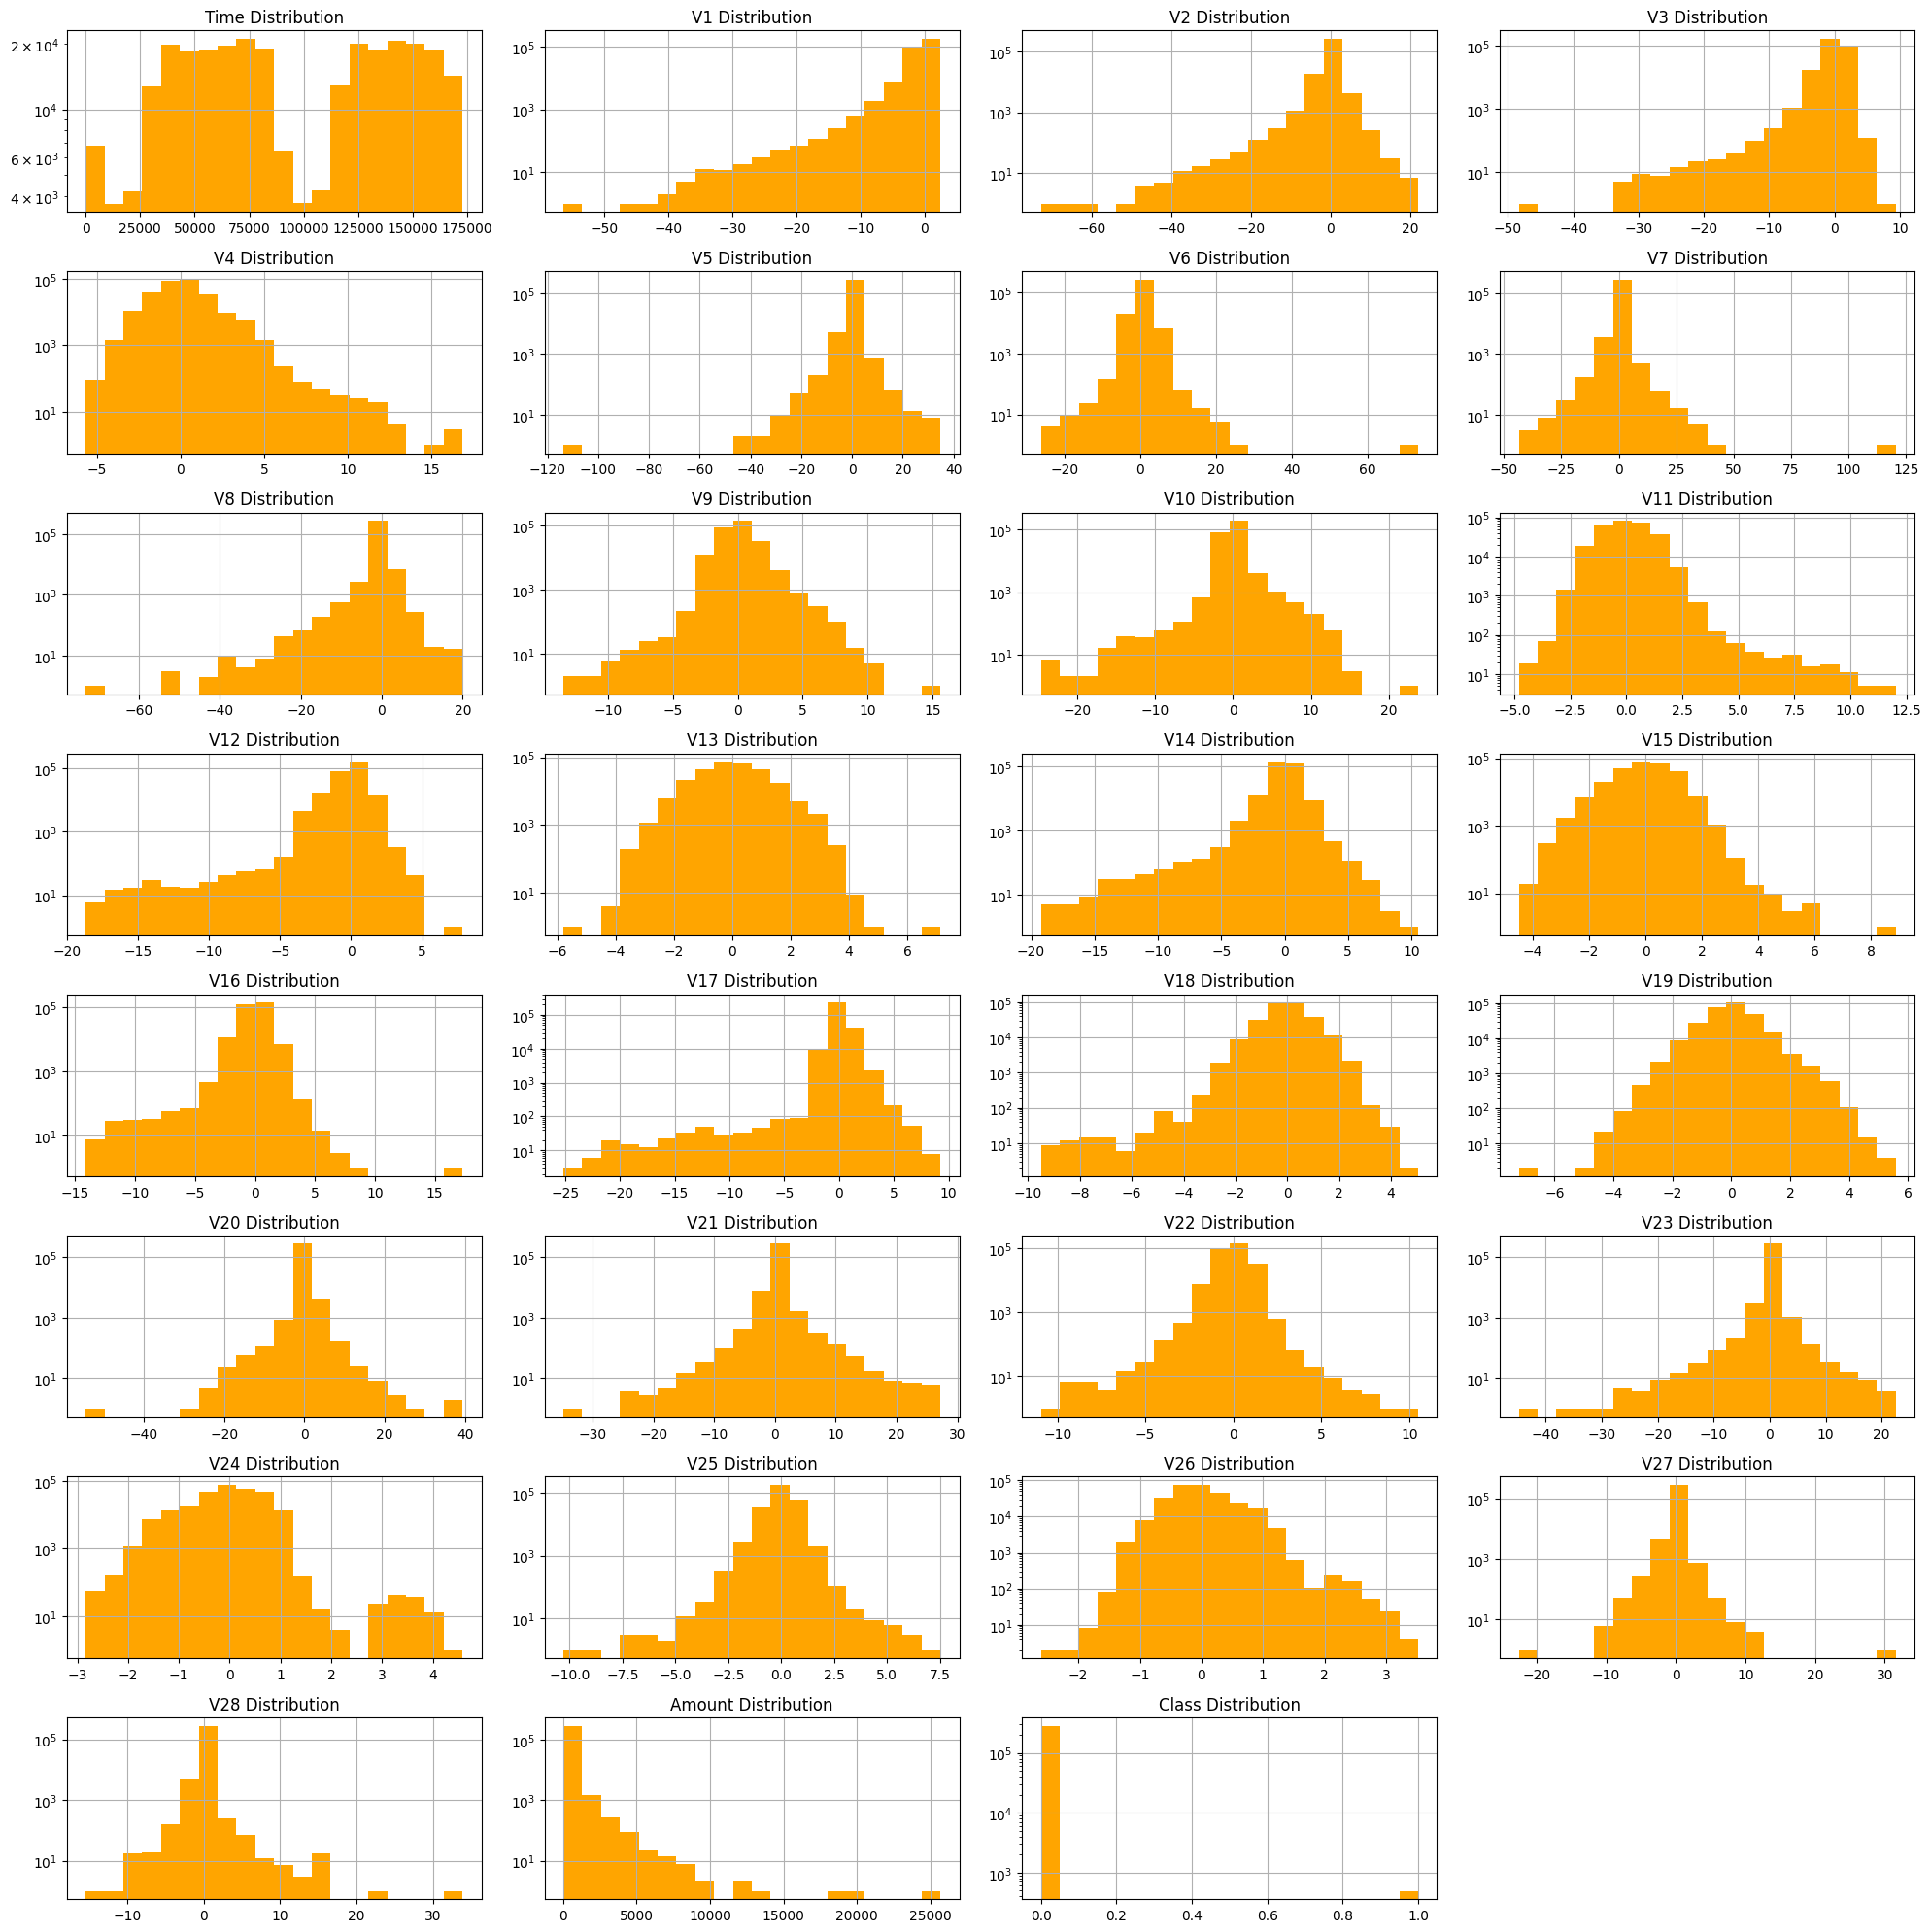

In [ ]:
draw_histograms(card,card.columns,8,4)

In [9]:
import plotly.figure_factory as ff
from plotly.offline import iplot

class_0 = card.loc[card['Class'] == 0]["Time"]
class_1 = card.loc[card['Class'] == 1]["Time"]
hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

colors = ['Red', 'DarkBlue']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False, colors=colors)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')


In [ ]:
df.Class.value_counts()

0    283253
1       473
Name: Class, dtype: int64

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE


X = df.drop(columns=['Class'])  # Features
y = df['Class']  # Target variable

print("Before balancing:")
print(y.value_counts())


smote = SMOTE(random_state=42)

X_balanced, y_balanced = smote.fit_resample(X, y)

print("\nAfter balancing:")
print(y_balanced.value_counts())


Before balancing:
0    283253
1       473
Name: Class, dtype: int64

After balancing:
0    283253
1    283253
Name: Class, dtype: int64


In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming 'Class' is the response variable and all other columns are features
X = df.drop(columns=['Class'])  # Features
y = df['Class']  # Response variable

# Splitting the data into train and test sets (optional)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display counts before balancing
print("Before balancing:")
print(pd.Series(y_train).value_counts())

# Initialize SMOTE to create synthetic samples for balancing
smote = SMOTE(random_state=42)

# Balancing the dataset using SMOTE
X_balanced, y_balanced = smote.fit_resample(X_train, y_train)

# Display counts after balancing
print("\nAfter balancing:")
print(pd.Series(y_balanced).value_counts())


Before balancing:
0    226597
1       383
Name: Class, dtype: int64

After balancing:
0    226597
1    226597
Name: Class, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming X_balanced contains features and y_balanced contains target variable after balancing
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


models = {

    'XGBoost': XGBClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}


for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)

    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{confusion}\n")

    disp = plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
    disp.ax_.set_title(f'Confusion Matrix - {name}')
    plt.show()

Model: XGBoost
Accuracy: 0.8950, Precision: 0.9327, Recall: 0.8739, F1 Score: 0.9023
Confusion Matrix:
[[82  7]
 [14 97]]



NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Generate some sample data (Replace this with your X_train, X_test, y_train, y_test)
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'XGBoost': XGBClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)

    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{confusion}\n")



Model: XGBoost
Accuracy: 0.8950, Precision: 0.9327, Recall: 0.8739, F1 Score: 0.9023
Confusion Matrix:
[[82  7]
 [14 97]]

Model: Random Forest
Accuracy: 0.8800, Precision: 0.9223, Recall: 0.8559, F1 Score: 0.8879
Confusion Matrix:
[[81  8]
 [16 95]]

Model: Logistic Regression
Accuracy: 0.8300, Precision: 0.8667, Recall: 0.8198, F1 Score: 0.8426
Confusion Matrix:
[[75 14]
 [20 91]]



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load your dataset
# Assuming your dataset is loaded into a DataFrame called 'data'
# Replace 'data.csv' with your actual file name or path



X = df.drop('Class', axis=1)  # Features
y = df['Class']               # Target variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)


rf_classifier.fit(X_train, y_train)


y_pred = rf_classifier.predict(X_test)


print("Random Forest Classifier Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Random Forest Classifier Performance:
Accuracy: 0.9995418179254926
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.97      0.73      0.84        90

    accuracy                           1.00     56746
   macro avg       0.99      0.87      0.92     56746
weighted avg       1.00      1.00      1.00     56746



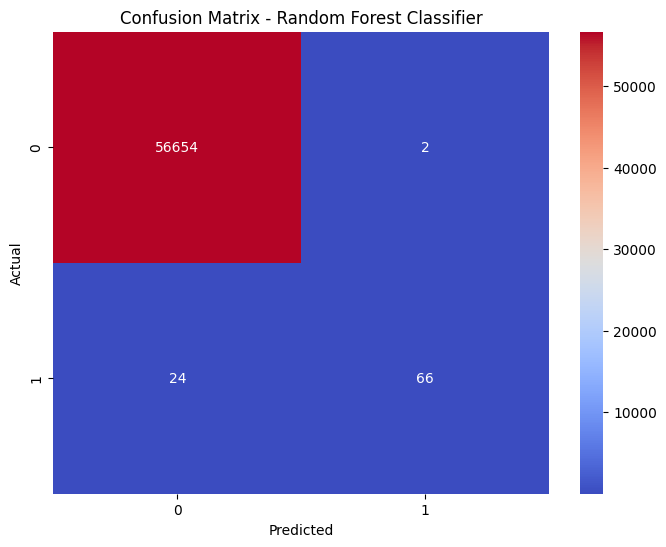

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest

# Assuming 'df' is your dataset, replace it with the actual DataFrame containing your data
# Check for and handle null values if present
df.dropna(inplace=True)

# Check for non-numeric columns and remove them if necessary
non_numeric_cols = df.select_dtypes(exclude=['float64', 'int64']).columns
if len(non_numeric_cols) > 0:
    df.drop(columns=non_numeric_cols, inplace=True)

# Separate features and target variable
X = df.drop('Class', axis=1)
y = df['Class']

# Rename columns to ensure they have valid names
X.columns = ['V' + str(i) for i in range(1, len(X.columns) + 1)]

# Initialize the Isolation Forest model
isolation_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

# Fit the model and predict anomalies
isolation_forest.fit(X)
anomaly_scores = isolation_forest.decision_function(X)



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_classifier = XGBClassifier(n_estimators=100, random_state=42)

xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)

print("XGBoost Classifier Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


XGBoost Classifier Performance:
Accuracy: 0.9995065731505305
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.96      0.72      0.82        90

    accuracy                           1.00     56746
   macro avg       0.98      0.86      0.91     56746
weighted avg       1.00      1.00      1.00     56746



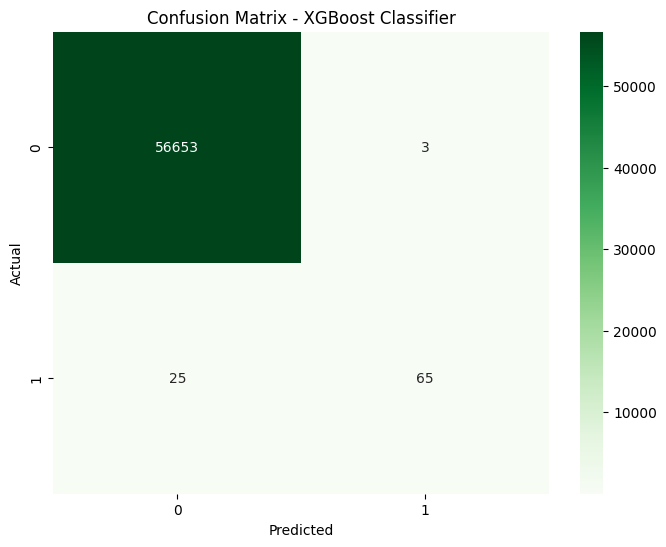

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your dataset, replace it with the actual DataFrame containing your data
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_classifier = XGBClassifier(n_estimators=100, random_state=42)

xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d')
plt.title('Confusion Matrix - XGBoost Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'df' is your dataset, replace it with the actual DataFrame containing your data
X = df.drop('Class', axis=1)
y = df['Class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression(max_iter=1000, random_state=42)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Logistic Regression Performance:
Accuracy: 0.9990307686885419
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.83      0.49      0.62        90

    accuracy                           1.00     56746
   macro avg       0.91      0.74      0.81     56746
weighted avg       1.00      1.00      1.00     56746



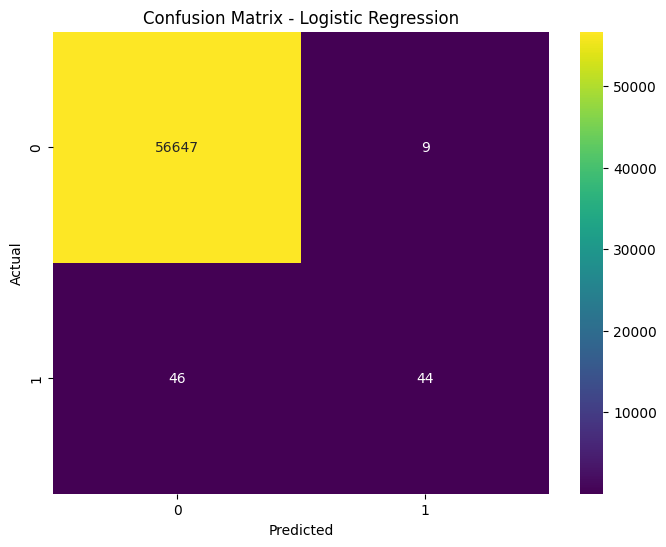

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your dataset, replace it with the actual DataFrame containing your data
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression(max_iter=1000, random_state=42)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='viridis', fmt='d')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


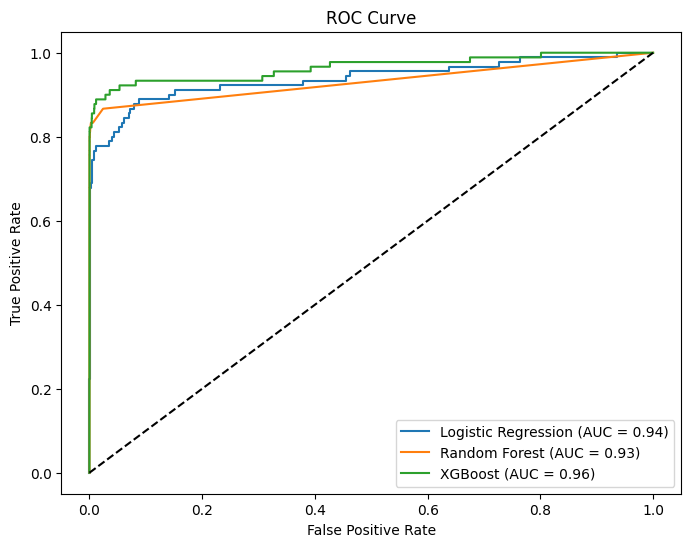

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming 'df' is your dataset, replace it with the actual DataFrame containing your data
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
logreg = LogisticRegression(max_iter=1000, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_classifier = XGBClassifier(n_estimators=100, random_state=42)

# Fit models
logreg.fit(X_train, y_train)
rf_classifier.fit(X_train, y_train)
xgb_classifier.fit(X_train, y_train)

# Predict probabilities
logreg_probs = logreg.predict_proba(X_test)[:, 1]
rf_probs = rf_classifier.predict_proba(X_test)[:, 1]
xgb_probs = xgb_classifier.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC for each model
logreg_fpr, logreg_tpr, _ = roc_curve(y_test, logreg_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

logreg_auc = roc_auc_score(y_test, logreg_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(logreg_fpr, logreg_tpr, label=f'Logistic Regression (AUC = {logreg_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'df' is your dataset, replace it with the actual DataFrame containing your data
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nb_classifier = GaussianNB()

nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

print("Naive Bayes Classifier Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Naive Bayes Classifier Performance:
Accuracy: 0.9928629330701724
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56656
           1       0.12      0.56      0.20        90

    accuracy                           0.99     56746
   macro avg       0.56      0.77      0.60     56746
weighted avg       1.00      0.99      1.00     56746



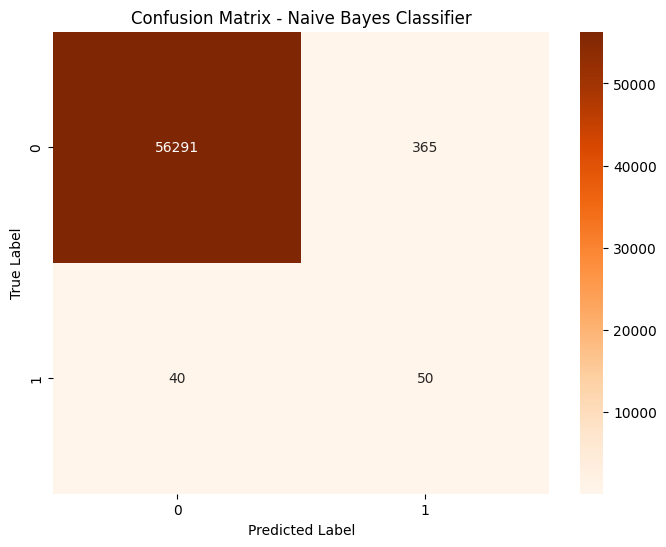

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your dataset, replace it with the actual DataFrame containing your data
X = df.drop('Class', axis=1)
y = df['Class']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Naive Bayes classifier (Gaussian Naive Bayes for continuous features)
nb_classifier = GaussianNB()

# Fit the classifier on the training data
nb_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = nb_classifier.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Oranges', fmt='d')
plt.title('Confusion Matrix - Naive Bayes Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Logistic Regression AUC: 0.938
Random Forest AUC: 0.931
XGBoost AUC: 0.965
Naive Bayes AUC: 0.961


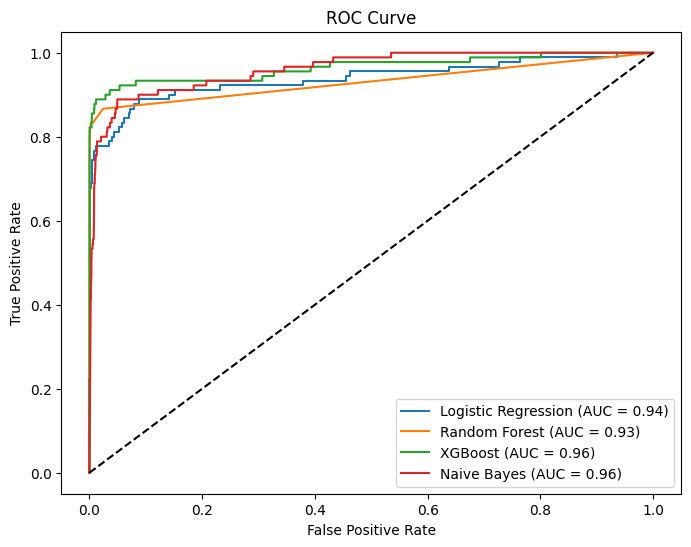

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming 'df' is your dataset, replace it with the actual DataFrame containing your data
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
logreg = LogisticRegression(max_iter=1000, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_classifier = XGBClassifier(n_estimators=100, random_state=42)
nb_classifier = GaussianNB()

# Fit models
logreg.fit(X_train, y_train)
rf_classifier.fit(X_train, y_train)
xgb_classifier.fit(X_train, y_train)
nb_classifier.fit(X_train, y_train)

# Predict probabilities
logreg_probs = logreg.predict_proba(X_test)[:, 1]
rf_probs = rf_classifier.predict_proba(X_test)[:, 1]
xgb_probs = xgb_classifier.predict_proba(X_test)[:, 1]
nb_probs = nb_classifier.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC for each model
logreg_fpr, logreg_tpr, _ = roc_curve(y_test, logreg_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)

logreg_auc = roc_auc_score(y_test, logreg_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)
nb_auc = roc_auc_score(y_test, nb_probs)

# Print AUC scores
print(f"Logistic Regression AUC: {logreg_auc:.3f}")
print(f"Random Forest AUC: {rf_auc:.3f}")
print(f"XGBoost AUC: {xgb_auc:.3f}")
print(f"Naive Bayes AUC: {nb_auc:.3f}")

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(logreg_fpr, logreg_tpr, label=f'Logistic Regression (AUC = {logreg_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot(nb_fpr, nb_tpr, label=f'Naive Bayes (AUC = {nb_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
